In [27]:
using Random, Gadfly, Optim, Distributions, Distances, LinearAlgebra, ForwardDiff, Cairo

include("../iGMRF.jl");
include("../dataGen.jl");
include("../approxFramework.jl");
include("../plotting.jl");
include("optim.jl");

In [5]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂;
# Matrice de structure
κᵤ = 100.0;
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;
# Génération de données
nobs = 100;
Y = generateData(grid_target, nobs);

In [6]:
res = KLOptim(F, Y)

 * Status: success

 * Candidate solution
    Final objective value:     -4.439463e-59

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    28
    f(x) calls:    388


## Analyse de l'approximation

### Visuelle

In [7]:
η̂ = Optim.minimizer(res)[1:m+1];
Σ̂ = diagm(Optim.minimizer(res)[m+2:end].^2);

d̂ = MvNormal(η̂, Σ̂);

Graphiques LOG

In [21]:
npoints = 10000; # Nombre de points sur lesquels évaluer la pdf
x = range(-10, 12, npoints);

# Mode de la posteriori
mode = findMode(θ -> functionalFormPosterior(θ, F=F, Y=Y), [1, fill(0.0, m)...]);
α = Optim.minimizer(mode);
gap = Optim.minimum(mode);

analysisSpace = zeros(m+1, npoints);
for j = 1:npoints
    analysisSpace[:, j] = [x[j], α[2:end]...];
end

simApprox = vec(mapslices(x -> logpdf(d̂, x), analysisSpace, dims=1));
simPosterior = vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), analysisSpace, dims=1));

p = plot(
    layer(x=x, y=simApprox, Geom.line, Theme(default_color="red")),
    layer(x=x, y=simPosterior, Geom.line),
    Guide.manual_color_key("Legend", ["Approximation", "Posteriori"], ["red", "deepskyblue"]),
    Theme(background_color="white"),
    Guide.title("Pour kappa_u")
)

draw(PNG("../plots/diag/log_kappa.png", dpi=300), p)

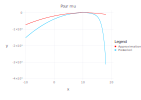

In [9]:
npoints = 10000; # Nombre de points sur lesquels évaluer la pdf
x = range(-10, 18, npoints);

# Mode de la posteriori
mode = findMode(θ -> functionalFormPosterior(θ, F=F, Y=Y), [1, fill(0.0, m)...]);
α = Optim.minimizer(mode);
gap = Optim.minimum(mode);

analysisSpace = zeros(m+1, npoints);
for j = 1:npoints
    analysisSpace[:, j] = [α[1], x[j], α[3:end]...];
end

simApprox = vec(mapslices(x -> logpdf(d̂, x), analysisSpace, dims=1));
simPosterior = vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), analysisSpace, dims=1));

p = plot(
    layer(x=x, y=simApprox, Geom.line, Theme(default_color="red")),
    layer(x=x, y=simPosterior, Geom.line),
    Guide.manual_color_key("Legend", ["Approximation", "Posteriori"], ["red", "deepskyblue"]),
    Theme(background_color="white"),
    Guide.title("Pour mu")
)

draw(PNG("../plots/diag/log_mu.png", dpi=300), p)

Approx vs MCMC

In [10]:
include("../mcmc.jl");

niter = 10000
δ² = 0.2
κᵤ₀ = 10
μ₀ = zeros(m)

θ = gibbs(niter, Y, m₁=m₁, m₂=m₂, δ²=δ², κᵤ₀=κᵤ₀, μ₀=μ₀);

warming_size = Int(0.2 * niter);
θsampling = θ[warming_size:end, :, :];

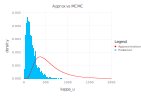

In [28]:
# Pour κᵤ

approxDensity(x::Real) = 1/x * pdf(Normal(η̂[1], sqrt(Σ̂[1, 1])), log(x))
a = 0;
step = 0.1;
b = 2000;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 1, 1],
    # "../plots/diag/approxvsmcmc_kappa.png",
    a=a,
    b=b,
    step=step;
    xLabel="kappa_u",
    yLabel="density",
)

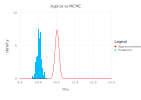

In [29]:
# Pour μ

approxDensity(x::Real) = pdf(Normal(η̂[2], sqrt(Σ̂[2, 2])), x)
a = 9.5;
step = .01;
b = 12;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 2, 1],
    # "../plots/diag/approxvsmcmc_mu.png",
    a=a,
    b=b,
    step=step,
    xLabel="mu",
    yLabel="density",
)